In [1]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as skm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def prepare_dataset(X_dataset, y_dataset, classes, n_samples):
    if n_samples is None:
        img_samples = X_dataset.shape[0]
    else:
        img_samples = n_samples

    df_aux = pd.DataFrame(columns=['id', 'label'])

    list_aux = []

    for i in range(img_samples):
        nm_file = str(i)+'-'+str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')+'.'+'png'
        sample = {'id':nm_file, 'label':str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')}
        list_aux.append(sample)

    return pd.concat([df_aux, pd.DataFrame(list_aux)], ignore_index=True)


def create_files(X_dataset, y_dataset, classes, dir, n_samples):
    if n_samples is None:
        img_samples = X_dataset.shape[0]
    else:
        img_samples = n_samples

    for i in range(img_samples):
        nm_file = str(i)+'-'+str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')+'.'+'png'
        img = X_dataset[i]
        plt.imsave(dir + nm_file, img)


def create_directory(dir):
    if os.path.exists(dir):
        for file in os.listdir(dir):
            os.remove(dir+file)
    else:
        os.makedirs(dir)


def plot_loss(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Gráfico loss X epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [3]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [38]:
train_dir = "./train/"
test_dir = "./test/" 

create_directory(train_dir)
create_directory(test_dir)

In [5]:
train_samples = 500 #X_train.shape[0]

create_files(X_train, y_train, cifar10_classes, train_dir, train_samples)

train_df = prepare_dataset(X_train, y_train, cifar10_classes, train_samples)

train_df.head()

,id,label
0,0-frog.png,frog
1,1-truck.png,truck
2,2-truck.png,truck
3,3-deer.png,deer
4,4-automobile.png,automobile


In [6]:
test_samples = 100 #X_test.shape[0]

create_files(X_test, y_test, cifar10_classes, test_dir, test_samples)

test_df = prepare_dataset(X_test, y_test, cifar10_classes, test_samples)

test_df.head()

,id,label
0,0-cat.png,cat
1,1-ship.png,ship
2,2-ship.png,ship
3,3-airplane.png,airplane
4,4-frog.png,frog


label
automobile    65
truck         56
frog          53
airplane      51
deer          50
horse         50
cat           47
ship          45
bird          43
dog           40
Name: count, dtype: int64


<Axes: title={'center': 'Dados para Treinamento por classe'}, xlabel='label'>

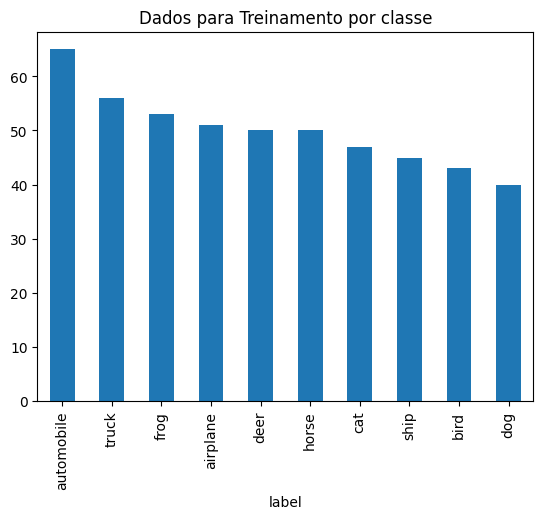

In [7]:
print((train_df['label']).value_counts())
train_df['label'].value_counts().plot.bar(title='Dados para Treinamento por classe')

label
frog          16
ship          13
truck         11
horse         11
cat           10
airplane      10
dog            8
bird           8
deer           7
automobile     6
Name: count, dtype: int64


<Axes: title={'center': 'Dados para Teste por classe'}, xlabel='label'>

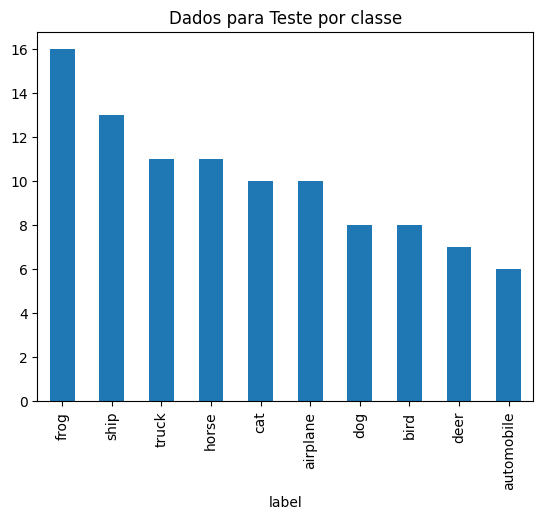

In [8]:
print((test_df['label']).value_counts())
test_df['label'].value_counts().plot.bar(title='Dados para Teste por classe')

In [9]:
print('Total de imagens para treinamento: %s' % len(os.listdir(train_dir)))
print('Total de imagens para teste      : %s' % len(os.listdir(test_dir)))

Total de imagens para treinamento: 500
Total de imagens para teste      : 100


Classes: ['frog', 'truck', 'truck', 'deer', 'automobile']


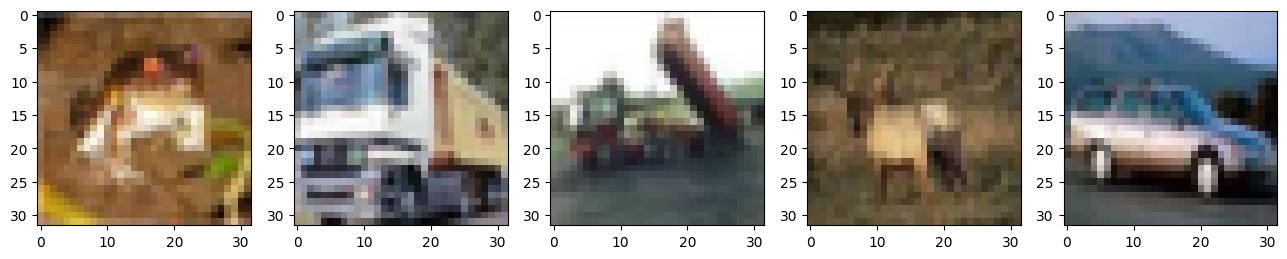

In [10]:
fig, x = plt.subplots(1, 5)
fig.set_size_inches(16, 6)

print('Classes: ' + str([cifar10_classes[x[0]] for x in y_train[0:5]]))

for i in range(5):
    image = X_train[i]
    x[i].imshow(image)
plt.show()

In [12]:
train_datagen=ImageDataGenerator(rescale=1.0/255.0,
                                validation_split=0.25,
                                rotation_range=30,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                horizontal_flip=True                                
                                )

train_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory=train_dir,
x_col="id",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory=train_dir,
x_col="id",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

Found 375 validated image filenames belonging to 10 classes.


Found 125 validated image filenames belonging to 10 classes.


In [13]:
test_datagen=ImageDataGenerator(rescale=1.0/255.0)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory=test_dir,
x_col="id",
y_col="label",
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(32,32))

Found 100 validated image filenames belonging to 10 classes.


In [14]:
train_step_size = train_generator.n//train_generator.batch_size
validation_step_size = valid_generator.n//valid_generator.batch_size

In [19]:
# Modelo 1

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit_generator(generator=train_generator,
          validation_data=valid_generator,
          steps_per_epoch=train_step_size,
          validation_steps=validation_step_size,
          epochs=15)

Epoch 1/15
11/11 [==============================] - 1s 79ms/step - loss: 2.3183 - accuracy: 0.1370 - val_loss: 2.2913 - val_accuracy: 0.1771
Epoch 2/15
11/11 [==============================] - 1s 58ms/step - loss: 2.2954 - accuracy: 0.1254 - val_loss: 2.2871 - val_accuracy: 0.1771
Epoch 3/15
11/11 [==============================] - 1s 57ms/step - loss: 2.2419 - accuracy: 0.1662 - val_loss: 2.2589 - val_accuracy: 0.1667
Epoch 4/15
11/11 [==============================] - 1s 58ms/step - loss: 2.1441 - accuracy: 0.1837 - val_loss: 2.1684 - val_accuracy: 0.2396
Epoch 5/15
11/11 [==============================] - 1s 58ms/step - loss: 2.0676 - accuracy: 0.2303 - val_loss: 2.0850 - val_accuracy: 0.2500
Epoch 6/15
11/11 [==============================] - 1s 57ms/step - loss: 1.9740 - accuracy: 0.2770 - val_loss: 1.9994 - val_accuracy: 0.2292
Epoch 7/15
11/11 [==============================] - 1s 58ms/step - loss: 1.9176 - accuracy: 0.3003 - val_loss: 1.9471 - val_accuracy: 0.2292
Epoch 8/15
11

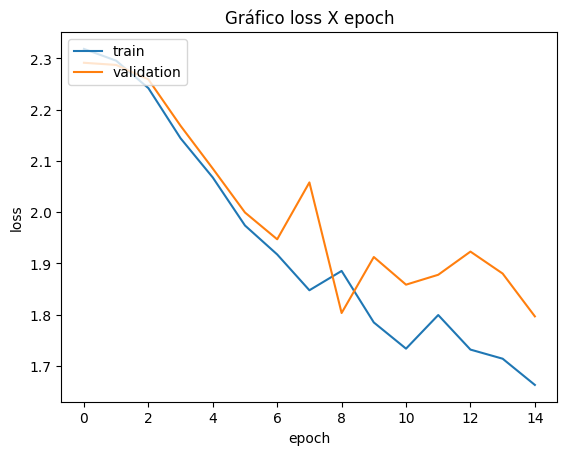

In [21]:
plot_loss(history)

In [22]:
loss, accuracy = model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.350000  ;  loss = 1.829517 


In [30]:
# Modelo 2

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
history = model.fit_generator(generator=train_generator,
          steps_per_epoch=train_step_size,
          validation_data=valid_generator,
          validation_steps=validation_step_size,
          epochs=15)

Epoch 1/15
11/11 [==============================] - 1s 82ms/step - loss: 2.3056 - accuracy: 0.1108 - val_loss: 2.3075 - val_accuracy: 0.1458
Epoch 2/15
11/11 [==============================] - 1s 59ms/step - loss: 2.2635 - accuracy: 0.1335 - val_loss: 2.3019 - val_accuracy: 0.0417
Epoch 3/15
11/11 [==============================] - 1s 58ms/step - loss: 2.2504 - accuracy: 0.1603 - val_loss: 2.2430 - val_accuracy: 0.1146
Epoch 4/15
11/11 [==============================] - 1s 61ms/step - loss: 2.1433 - accuracy: 0.2070 - val_loss: 2.1813 - val_accuracy: 0.1250
Epoch 5/15
11/11 [==============================] - 1s 60ms/step - loss: 2.1367 - accuracy: 0.2362 - val_loss: 2.1228 - val_accuracy: 0.2188
Epoch 6/15
11/11 [==============================] - 1s 59ms/step - loss: 2.0150 - accuracy: 0.2770 - val_loss: 2.0217 - val_accuracy: 0.3229
Epoch 7/15
11/11 [==============================] - 1s 62ms/step - loss: 1.9753 - accuracy: 0.2974 - val_loss: 1.9506 - val_accuracy: 0.2604
Epoch 8/15
11

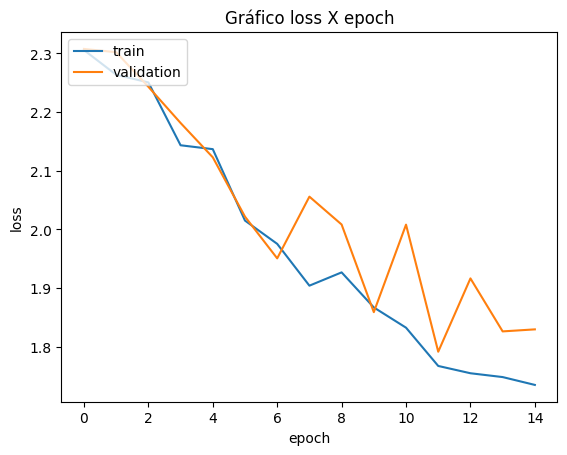

In [32]:
plot_loss(history)

In [33]:
loss, accuracy = model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.270000  ;  loss = 1.883506 


In [34]:
 # Modelo 3

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
history = model.fit_generator(generator=train_generator,
          steps_per_epoch=train_step_size,
          validation_data=valid_generator,
          validation_steps=validation_step_size,
          epochs=15)

Epoch 1/15
11/11 [==============================] - 2s 111ms/step - loss: 3.9538 - accuracy: 0.1749 - val_loss: 2.3257 - val_accuracy: 0.0938
Epoch 2/15
11/11 [==============================] - 1s 103ms/step - loss: 3.3285 - accuracy: 0.2332 - val_loss: 2.4051 - val_accuracy: 0.0833
Epoch 3/15
11/11 [==============================] - 1s 104ms/step - loss: 3.2825 - accuracy: 0.2128 - val_loss: 2.4738 - val_accuracy: 0.1146
Epoch 4/15
11/11 [==============================] - 1s 103ms/step - loss: 2.7817 - accuracy: 0.3239 - val_loss: 2.6550 - val_accuracy: 0.1042
Epoch 5/15
11/11 [==============================] - 1s 101ms/step - loss: 2.7006 - accuracy: 0.2566 - val_loss: 2.5978 - val_accuracy: 0.0938
Epoch 6/15
11/11 [==============================] - 1s 101ms/step - loss: 2.6212 - accuracy: 0.2945 - val_loss: 2.9557 - val_accuracy: 0.0729
Epoch 7/15
11/11 [==============================] - 1s 100ms/step - loss: 2.2996 - accuracy: 0.3265 - val_loss: 3.1924 - val_accuracy: 0.0729
Epoch 

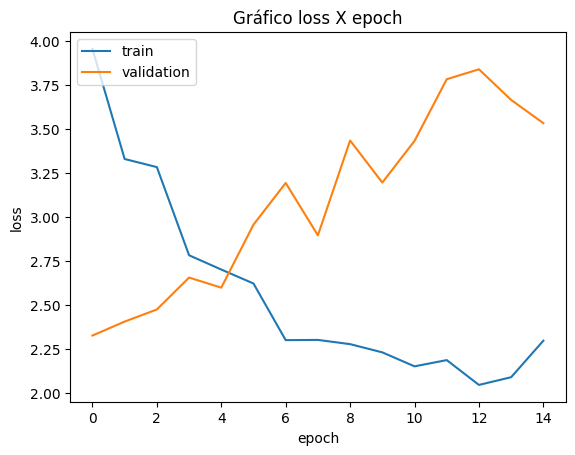

In [36]:
plot_loss(history)

In [37]:
loss, accuracy = model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.070000  ;  loss = 3.475106 


In [ ]:
test_generator.reset()

count = 0
y_pred = list()
y_true = list()
class_names = cifar10_classes

for batch in test_generator:
    count+=1

    if count == len(test_generator)+1:
        break
    else:
        images = batch[0]
        labels = batch[1]
        predictions = model.predict(images)

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            prediction = predictions[i]

            predicted_class = np.argmax(prediction)
            probability = prediction[predicted_class]
            class_name = class_names[int(predicted_class)]
            y_pred.append(class_name)

            labeled_class = np.argmax(label)
            label = class_names[int(labeled_class)]
            y_true.append(label)

In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":y_pred})
results.to_csv("results_deep_learning.csv",index=False)

In [ ]:
loss, accuracy = model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

In [ ]:
accuracy = skm.accuracy_score(y_true, y_pred)
precision = skm.precision_score(y_true, y_pred, average='weighted')
recall = skm.recall_score(y_true, y_pred, average='weighted')
f1score = skm.f1_score(y_true, y_pred, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1score)

In [ ]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
np.set_printoptions(precision=2)

fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.matshow(cnf_matrix, cmap=plt.cm.Blues, alpha=0.3, interpolation = 'nearest')
plt.gca().xaxis.tick_bottom()

tick_marks = np.arange(len(cifar10_classes))
plt.xticks(tick_marks, cifar10_classes, rotation=45)
plt.yticks(tick_marks, cifar10_classes)

for i in range(cnf_matrix.shape[0]):
    for j in range(cnf_matrix.shape[1]):
        ax.text(x=j, y=i,s=cnf_matrix[i, j], va='center', ha='center')

fig.colorbar(cax)

plt.xlabel('Predição', fontsize=13)
plt.ylabel('Real', fontsize=13)
plt.title('Matriz de Confusão', fontsize=18)
plt.show()

In [ ]:
'''

model_dir = "./trained_models/"
create_directory(model_dir)

# obtendo a data e hora atual
now = datetime.now()

# Definição do formato
format = '%Y-%m-%dT%H%M'

# Converter a data e hora em uma string com o formato especificado
formatted_datetime = now.strftime(format)

model_name = 'trained_model_deep_learning' + formatted_datetime + '.h5'

# salvando o modelo
model.save("%s/%s" % (model_dir, model_name))
print("Modelo salvo com o nome: ", model_name)

'''

In [ ]:
'''

model_loaded = keras.models.load_model("%s/%s" % (model_dir, model_name))
print("Modelo %s carregado com sucesso" % (model_name))

'''

In [ ]:
'''

test_generator.reset()

count = 0
y_pred = list()
y_true = list()
class_names = cifar10_classes

# Loop do data generator de teste que contem as imagens
for batch in test_generator:

    count+=1

    # Condição de saída do loop. Só executaremos o modelo em algumas imagens
    if count == len(test_generator)+1:
        break

    else:
        # Pegando a imagem e o label
        images = batch[0]
        labels = batch[1]

        # Previsão
        predictions = model_loaded.predict(images)

        # Visualização da imagem
        for i in range(len(images)):

            image = images[i]
            label = labels[i]

            prediction = predictions[i]

            # Converte o array de previsão para visualizar a classe e a probabilidade
            predicted_class = np.argmax(prediction)
            probability = prediction[predicted_class]

            labeled_class = np.argmax(label)
            label = class_names[int(labeled_class)]

            y_true.append(label)

            # Faz o DE-PARA da probabilidade com o tipo de classe da previsão
            # class_name = 'dog' if prediction >= 0.5 else 'cat'

            class_name = class_names[int(predicted_class)]

            y_pred.append(class_name)

'''

In [ ]:
'''

filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":y_pred})
results.to_csv("results_deep_learning_trained.csv",index=False)

'''